### 라이브러리 불러오기

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import PIL.Image

### 데이터 준비

In [5]:
dir = 'https://github.com/SUNGBEOMCHOI/Paper_implementation/blob/main/Style%20Transfer/image'
content_img_path = dir + '/content_img1.jpg?raw=true' # content 이미지의 url을 입력
style_img_path = dir + '/style_img1.jpg?raw=true'
os.mkdir('./image') #image라는 폴더를 생성
content_img_path = tf.keras.utils.get_file(os.getcwd()+'/image/content_img1.jpg', content_img_path)
style_img_path = tf.keras.utils.get_file(os.getcwd()+'/image/style_img1.jpg', style_img_path)

401408/398342 [==============================] - 0s 0us/step


In [6]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3, dtype=tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # axis=0의 차원 증가
    return img

def show_image(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0) # axis-0의 차원 축소
    
    plt.imshow(image)
    if title:
        plt.title(title)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [7]:
content_image = load_img(content_img_path)
style_image = load_img(style_img_path)

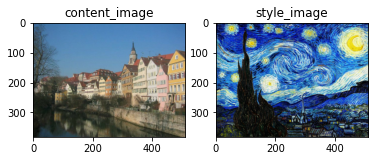

In [8]:
plt.subplot(1, 2, 1)
show_image(content_image, 'content_image')
plt.subplot(1, 2, 2)
show_image(style_image, 'style_image')

### 모델 준비
- 사전훈련된 VGG 모델에서 feature extractor만 불러옵니다.

In [9]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

def vgg_layers(layer_names):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [10]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

### 스타일 계산하기

In [11]:
def gram_matrix(input_tensor):
    result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
      super(StyleContentModel, self).__init__()
      self.vgg =  vgg_layers(style_layers + content_layers)
      self.style_layers = style_layers
      self.content_layers = content_layers
      self.num_style_layers = len(style_layers)
      self.vgg.trainable = False

    def call(self, inputs):
      "[0,1] 사이의 실수 값을 입력으로 받습니다"
      inputs = inputs*255.0
      preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
      outputs = self.vgg(preprocessed_input)
      style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                        outputs[self.num_style_layers:])

      style_outputs = [gram_matrix(style_output)
                       for style_output in style_outputs]

      content_dict = {content_name:value 
                      for content_name, value 
                      in zip(self.content_layers, content_outputs)}

      style_dict = {style_name:value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}

      return {'content':content_dict, 'style':style_dict}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

80142336/80134624 [==============================] - 1s 0us/step


### 경사하강법 실행

In [14]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
image = tf.Variable(content_image) # content_image와 똑같은 tensor 생성, 변화시킬 이미지

In [16]:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_outputs)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_outputs)
    loss = style_loss + content_loss
    return loss

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

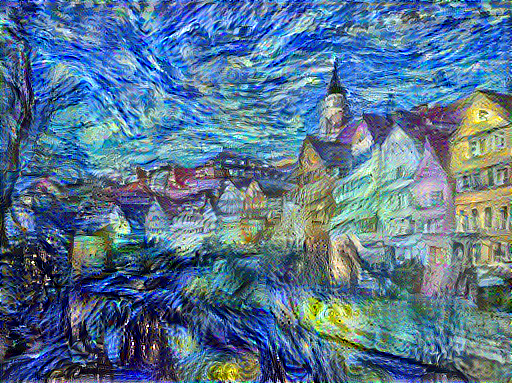

훈련스텝: 1000


In [18]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f'훈련스텝: {step}')